In [2]:
!git clone https://github.com/triple-Mu/YOLOv8-TensorRT.git

Cloning into 'YOLOv8-TensorRT'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 747 (delta 188), reused 285 (delta 161), pack-reused 410
Receiving objects: 100% (747/747), 824.57 KiB | 22.90 MiB/s, done.
Resolving deltas: 100% (386/386), done.


In [2]:
# export to engine model

# import torch
# from TensorRT.models import EngineBuilder

# onnx_model = 'models/nano/best.onnx'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# builder = EngineBuilder(onnx_model, device)
# builder.seg = True
# builder.build(fp16=True,
#               input_shape=[1, 3, 640, 640],
#               iou_thres=0.65,
#               conf_thres=0.25,
#               topk=100)

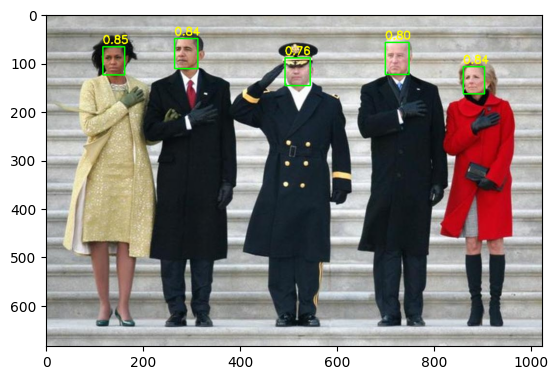

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from TensorRT.models.utils import blob, det_postprocess, letterbox
from TensorRT.models.cudart_api import TRTEngine

Engine = TRTEngine('models/nano/best.engine')
H, W = Engine.inp_info[0].shape[-2:]

img = cv2.imread('images/test.jpg')
draw = img.copy()

bgr, ratio, dwdh = letterbox(img, (W, H))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
tensor = blob(rgb, return_seg=False)
dwdh = np.array(dwdh * 2, dtype=np.float32)
tensor = np.ascontiguousarray(tensor)

data = Engine(tensor)
bboxes, scores, labels = det_postprocess(data)
bboxes -= dwdh
bboxes /= ratio

for (bbox, score) in zip(bboxes, scores):
  box = bbox.round().astype(np.int32).tolist()
  cv2.rectangle(draw, box[:2], box[2:], (0,255,0), 2)
  cv2.putText(draw, str(score)[:4], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)

plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
plt.show()

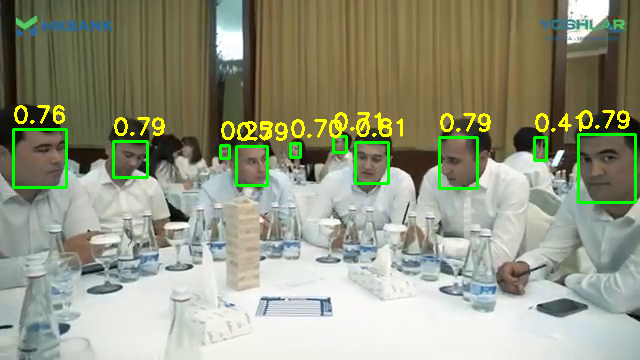

In [ ]:
# this code is for colab

from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import time

cap = cv2.VideoCapture('images/test.mp4')

if (cap.isOpened()== False):
    print("Error opening video file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        bgr, ratio, dwdh = letterbox(frame.copy(), (W, H))
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        tensor = blob(rgb, return_seg=False)
        dwdh = np.array(dwdh * 2, dtype=np.float32)
        tensor = np.ascontiguousarray(tensor)

        data = Engine(tensor)
        bboxes, scores, labels = det_postprocess(data)
        bboxes -= dwdh
        bboxes /= ratio

        for (bbox, score) in zip(bboxes, scores):
            box = bbox.round().astype(np.int32).tolist()
            cv2.rectangle(frame, box[:2], box[2:], (0,255,0), 2)
            cv2.putText(frame, str(score)[:4], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)

        clear_output(wait=True)
        cv2_imshow(frame)
        time.sleep(0.1)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()